# Quick intro to classification

### We will do this notebook from scratch in class

First we'll import some data. I'm using an extract from the Rock Property Catalog, https://subsurfwiki.org/wiki/Rock_Property_Catalog

In [1]:
import pandas as pd

df = pd.read_csv('https://geocomp.s3.amazonaws.com/data/RPC_simple.csv')

df.head()

,Vp,Vs,Rho_n,Lithology
0,3045.6,1595.7,2109.120585,sandstone
1,3000.6,1517.1,2090.342013,sandstone
2,3363.6,2041.5,2131.989982,sandstone
3,3195.3,1606.2,2184.939233,sandstone
4,4237.5,2448.6,2472.230768,sandstone


In [2]:
X = df[['Vp', 'Rho_n']].values
y = df.Lithology.values

In [3]:
X

array([[3045.6       , 2109.12058533],
       [3000.6       , 2090.34201313],
       [3363.6       , 2131.98998202],
       [3195.3       , 2184.93923335],
       [4237.5       , 2472.23076759],
       [4319.1       , 2458.95970795],
       [4533.        , 2397.13643415],
       [3538.5       , 2047.36213075],
       [3524.7       , 2210.52878324],
       [3565.2       , 2141.62021745],
       [3442.8       , 2194.58436216],
       [3352.2       , 2080.55014253],
       [3340.2       , 2158.17175506],
       [3318.9       , 2191.49367092],
       [4392.        , 2178.40040454],
       [3380.1       , 2007.89814337],
       [3085.2       , 2115.69860314],
       [3617.1       , 2187.03077846],
       [5406.        , 2115.25186245],
       [3620.7       , 2089.88017085],
       [4017.        , 2474.66067199],
       [3400.5       , 2132.70063559],
       [4349.4       , 2431.95294996],
       [3045.6       , 2060.48628626],
       [3206.7       , 2145.82173042],
       [3096.6       , 21

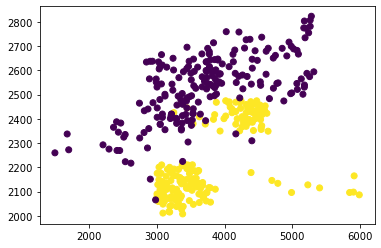

In [4]:
import matplotlib.pyplot as plt

plt.scatter(*X.T, c=y=='sandstone')

Could turn that awkward boolean into a function:

In [5]:
def is_sand(y):
    return y == 'sandstone'

## A linear model: SVM


### Instructor: briefly explain what an SVM does

In [6]:
from sklearn.svm import SVC

svc = SVC(kernel='linear')

svc.fit(X, y)

y_pred = svc.predict(X)

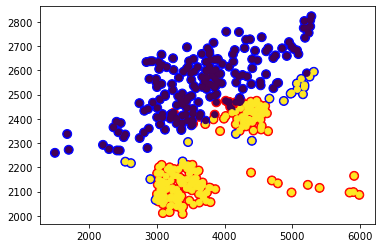

In [7]:
plt.scatter(*X.T, c=is_sand(y), s=80, cmap='bwr')
plt.scatter(*X.T, c=is_sand(y_pred))

In [8]:
from sklearn.metrics import accuracy_score

accuracy_score(y, y_pred)

0.9125

## Plot the decision boundary

We can visualize the decision boundary, and the class 'regions' using a small function in `utils.py`:

```python
def decision_regions(clf, X_val, y_val, extent, step=1):
    """
    Generate the decision surface of a classifier.
    """
    y_pred = clf.predict(X_val)
    x_min, x_max, y_min, y_max = extent
    try:
        x_step, y_step = step
    except TypeError:
        x_step = y_step = step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, x_step),
                         np.arange(y_min, y_max, y_step))
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    return y_pred, Z.reshape(xx.shape + (-1,))
```

Build up from this:

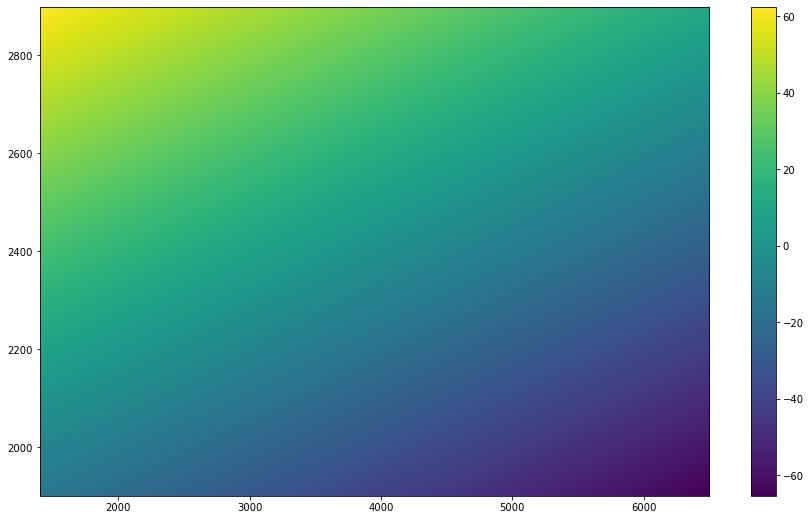

In [9]:
from utils import decision_regions

extent = [1400, 6500, 1900, 2900]
y_pred, y_all = decision_regions(svc, X, y, extent, step=2)
    
plt.figure(figsize=(15, 9))
plt.imshow(y_all, extent=extent, origin='lower', aspect='auto')
plt.colorbar()

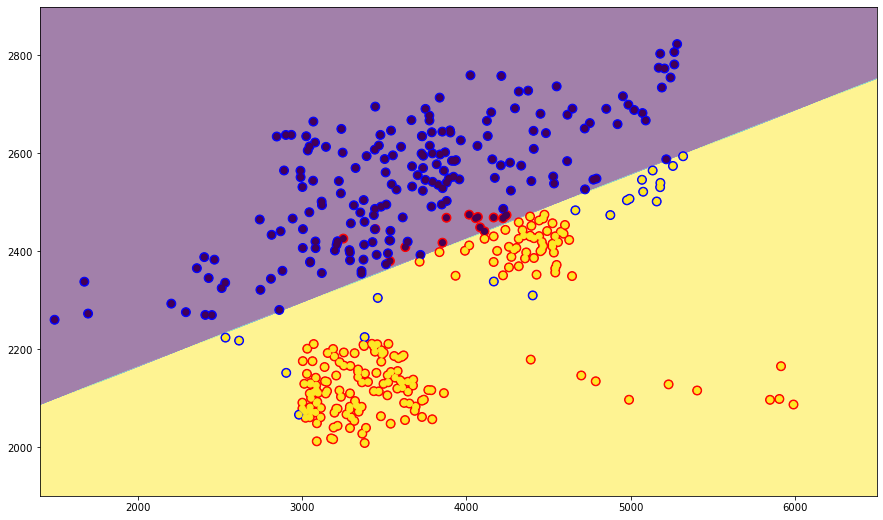

In [10]:
plt.figure(figsize=(15, 9))
plt.imshow(y_all <= 0.0, extent=extent, origin='lower', aspect='auto', alpha=0.5)
plt.scatter(*X.T, c=is_sand(y), s=80, cmap='bwr')
plt.scatter(*X.T, c=is_sand(y_pred))
plt.show()

## A non-linear SVM model

If we employ the **kernel trick** we can fit a nonlinear model. Scikit-learn's `SVC` actually uses this by default:

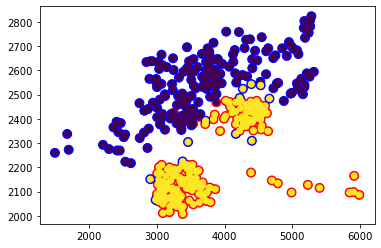

In [11]:
from sklearn.svm import SVC

svc = SVC()  # Default is kernel='rbf'

svc.fit(X, y)

y_pred = svc.predict(X)

plt.scatter(*X.T, c=is_sand(y), s=80, cmap='bwr')
plt.scatter(*X.T, c=is_sand(y_pred))

The score is better:

In [ ]:
accuracy_score(y, y_pred)

In [ ]:
y_pred, y_all = decision_regions(svc, X, y, extent, step=2)
    
plt.figure(figsize=(15, 9))
plt.imshow(y_all <= 0.0, extent=extent, origin='lower', aspect='auto', alpha=0.5)
plt.scatter(*X.T, c=is_sand(y), s=80, cmap='bwr')
plt.scatter(*X.T, c=is_sand(y_pred))
plt.show()

## Validation

We should not train the model, then check its accuracy only on that dataset. It's cheating.

Let's hold out some validation data, or 'blind' data.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

Now let's train a model *on only the training data* and validate it properly.

In [ ]:
svc = SVC().fit(X_train, y_train)

y_pred = svc.predict(X_val)

accuracy_score(y_val, y_pred)

## Standardize the data

Note that it's a good idea to train SVMs on the Z-scores of your data, i.e. zero mean, StdDev = 1. This ensures that the different scales of the features is not causing a problem. (They are about the same scale in our dataset so the effect is small.)

In [ ]:
plt.scatter(*X_train.T)
plt.axis('equal')

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

This doesn't change how the data are distributed:

In [ ]:
plt.scatter(*X_train.T)
plt.axis('equal')

But the results are better...

In [ ]:
svc = SVC(probability=True)

svc.fit(X_train, y_train)

svc.score(X_val, y_val)

## Draw the decision boundary

We tried using `mlxtend` here but it is not very accurate.

In [ ]:
extent = [-3.5, 3.5, -3, 3]
y_pred, y_all = decision_regions(svc, X_val, y_val, extent, step=0.02)
    
plt.figure(figsize=(15, 9))
plt.imshow(y_all <= 0.0, extent=extent, origin='lower', aspect='auto', alpha=0.5)
plt.scatter(*X_train.T, c=is_sand(y_train), marker='+', cmap='bwr')
plt.scatter(*X_val.T, c=is_sand(y_val), s=80, cmap='bwr')
plt.scatter(*X_val.T, c=is_sand(y_pred))
plt.show()

## Using this model

If we wanted to use our model now, we should now retrain it on all the data; presumably, this is at least as good as the one trained on the training set, we just don't have a way to check it now.

In [ ]:
scaler = StandardScaler().fit(X)
X_ = scaler.transform(X)
svc = SVC().fit(X_, y)

---
&copy; 2020 Agile Scientific CC-BY